> La carte d'occupation du sol de Wallonie de 2019 et la carte des changements ont été réalisées dans le cadre du marché de mise à jour de WalOUS 2018 entre le SPW et Aerospacelab. Ce notebook a été réalisé afin de former les utilisateurs à l'utilisation des données dérivées de ce marché.

# Atelier Utilisateurs #2
## Etude de cas: Détection de piscines

Dans cette étude de cas fictive, nous souhaitons isoler les piscines des autres étendues d'eau en utilisant uniquement les données de la carte d'occupation du sol.

Ce cas pratique nous permettra de toucher les points suivants:
- générer des données vectorisées
- dériver des attributs de ces données vectorisées
- rasteriser des données vectorisées sur la carte d'occupation des sols

_Certaines variables de ce notebook peuvent être adaptées pour rendre ce dernier plus proche de vos attentes. Ces variables seront nommées avec des majuscules._

Commençons par importer les librairies qui seront utilisées dans ce _notebook_:

In [1]:
from copy import deepcopy
from typing import Dict, List, Tuple, Union

from geojson import Feature
import geopandas as gpd
import numpy as np
from PIL import Image
import rasterio as rio
from rasterio.mask import mask
from rasterio.features import shapes, rasterize

Redéfinissons les variables et fonctions définies dans le _notebook_ __familiarisation__:

In [2]:
OCS_CMAP = {
    1: (138, 138, 138),
    2: (220, 15, 15),
    3: (78, 78, 78),
    4: (208, 208, 208),
    5: (36, 97, 247),
    6: (255, 255, 115),
    7: (233, 255, 190),
    8: (0, 50, 0),
    9: (40, 200, 40),
    11: (138, 138, 138),
    15: (138, 138, 138),
    18: (138, 138, 138),
    19: (138, 138, 138),
    28: (220, 15, 15),
    29: (220, 15, 15),
    31: (78, 78, 78),
    38: (78, 78, 78),
    39: (78, 78, 78),
    51: (36, 97, 247),
    55: (36, 97, 247),
    58: (36, 97, 247),
    59: (36, 97, 247),
    62: (255, 85, 0),
    71: (233, 255, 190),
    73: (233, 255, 190),
    75: (233, 255, 190),
    80: (0, 120, 0),
    81: (0, 50, 0),
    83: (0, 50, 0),
    85: (0, 50, 0),
    90: (183, 232, 176),
    91: (40, 200, 40),
    93: (40, 200, 40),
    95: (40, 200, 40),
    255: (255, 255, 255),  # Nodata
}

def to_mapping_array(mapping_dict: Dict[int, Union[int, List[int]]]) -> np.ndarray:
    k = np.array(list(mapping_dict.keys()))
    v = np.array(list(mapping_dict.values()))
    if v.ndim > 1:
        map_array_shape = (k.max() + 1, v.shape[1])
    else:
        map_array_shape = k.max() + 1
    mapping_array = np.zeros(map_array_shape, dtype="uint8")
    mapping_array[k] = v
    return mapping_array

def raster2img(data: np.ndarray, cmap: Dict[int, Tuple[int, int, int]] = OCS_CMAP):
    ocs_cmap_encoding = to_mapping_array(cmap)
    return Image.fromarray(ocs_cmap_encoding[data.squeeze()])

--------


#### Introduction

Pour illustrer cette étude de cas, nous choisissons de travailler avec la _tuile_ `LV3_2018__7_053A_00276`.

La démarche proposée dans ce _notebook_ est d'extraire du raster les pixels appartenant à la classe 5: Surfaces d'eau. Ces zones seront vectorisées afin de pouvoir calculer leurs aires et en dériver la `solidité` (i.e. un filtre basé sur la forme du polygone/zone). Ensuite, il restera à implementer des filtres pour ne garder parmi ces étendues d'eau que les piscines.<br>
Ainsi les étapes sont les suivantes:
1. Selectionner une _tuile_ et en extraire les données d'occupation du sol
2. Vectoriser les données de la carte d'occupation du sol
3. Filtrer les surfaces d'eau
4. Calculer leurs aires
5. Calculer leurs solidités
5. Filtrer les piscines
6. Visualiser les piscines en les appliquant à nouveau sur la _tuile_ de la carte d'occupation du sol


#### Selection de la _tuile_ et extraction des données d'occupation du sol

>_Objectifs_: Selectionner une _tuile_ depuis le fichier de tuilage et l'utiliser pour extraire les données de la carte d'occupation du sol s'y rapportant

Ainsi nous chargons dans un premier temps le fichier contenant les _tuiles_ utilisées pour diviser le territoire wallon. Ce fichier `ShapeFile` peut être ouvert et manipulé avec avec la librairie `geopandas` qui stockera les données dans un "tableau", appelé `GeoDataFrame`:

_Note: Adaptez le chemin d'accès vers le fichier de tuilage, si nécessaire_

In [3]:
TUILAGE_FP = "data/ORTHOS_2018_MAILLES_TUILES_SHAPE_31370.zip!SPW_2018_TUILAGE.shp"

tuilage_gdf = gpd.read_file(TUILAGE_FP)
tuilage_gdf.head(5)  # Affiche les 5 premières lignes du tableau

,OBJECTID,IMGLV3NAME,ACQ_TIME,ACQ_TIMEST,BANDS,RADIO_RES,SUN_ELEVAT,SUN_AZIMUT,AVG_HEIGHT,AER_HEIGHT,...,IMG_MOSDES,CKP_SOURCE,CKP_ACC_XY,CKP_ACC_Z,CKP_NUMBER,CKP_RMSE_X,CKP_RMSE_Y,CKP_RMSEXY,IMGORTNAME,geometry
0,6221.0,LV3_2018__1_029C_01910,20180626111738,11:17:38,4,64,62.52,169.6,607.61,4222.090,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00680136;ORTHO_2018__00680137,"POLYGON ((274014.770 137991.251, 274003.280 13..."
1,6222.0,LV3_2018__1_029C_01909,20180626111725,11:17:25,4,64,62.52,169.5,573.29,4222.090,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00680136;ORTHO_2018__00680137,"POLYGON ((275296.060 137953.431, 275296.060 13..."
2,6223.0,LV3_2018__1_029C_01908,20180626111712,11:17:12,4,64,62.51,169.4,593.80,4226.966,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00680137;ORTHO_2018__00680138,"POLYGON ((276272.500 137942.351, 276291.240 13..."
3,6224.0,LV3_2018__1_029C_01907,20180626111659,11:16:59,4,64,62.51,169.3,633.05,4230.929,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00680138,"POLYGON ((277411.140 137974.591, 277401.490 13..."
4,6230.0,LV3_2018__7_045A_00855,20180505123003,12:30:03,4,64,54.07,202.9,227.69,4458.005,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00660113;ORTHO_2018__00670113,"POLYGON ((226327.250 135944.131, 226385.350 13..."


Nous filtrons ensuite ce `GeoDataFrame` pour ne garder que la _tuile_ qui nous intéresse. Ici nous avons décidé de travailler avec la _tuile_ `LV3_2018__7_053A_00276`, libre à vous d'en choisir une autre.

In [4]:
IMGLV3NAME = "LV3_2018__7_053A_00276"  # Vous pouvez changer le nom de la tuile ici

tuile = tuilage_gdf[tuilage_gdf["IMGLV3NAME"]==IMGLV3NAME]
tuile

,OBJECTID,IMGLV3NAME,ACQ_TIME,ACQ_TIMEST,BANDS,RADIO_RES,SUN_ELEVAT,SUN_AZIMUT,AVG_HEIGHT,AER_HEIGHT,...,IMG_MOSDES,CKP_SOURCE,CKP_ACC_XY,CKP_ACC_Z,CKP_NUMBER,CKP_RMSE_X,CKP_RMSE_Y,CKP_RMSEXY,IMGORTNAME,geometry
5789,4726.0,LV3_2018__7_053A_00276,20180505095758,09:57:58,4,64,50.44,140.2,235.68,4416.362,...,Global tiling,PICC,0.15,0.3,7,0.23,0.18,0.29,ORTHO_2018__00540081;ORTHO_2018__00550081;ORTH...,"POLYGON ((163590.750 112660.191, 163621.250 11..."


Pour ce cas pratique, nous utiliserons la carte d'occupation du sol de 2019, c'est-à-dire WAL_OCS_IA__2019. Nous chargeons cette donnée avec la librairie `rasterio` et recoltons les données propres à la _tuile_ avec la fonction _mask_.

Ensuite nous visualisons ces données raster en utilisant la symbologie définie dans le _notebook_ __familiarisation__:

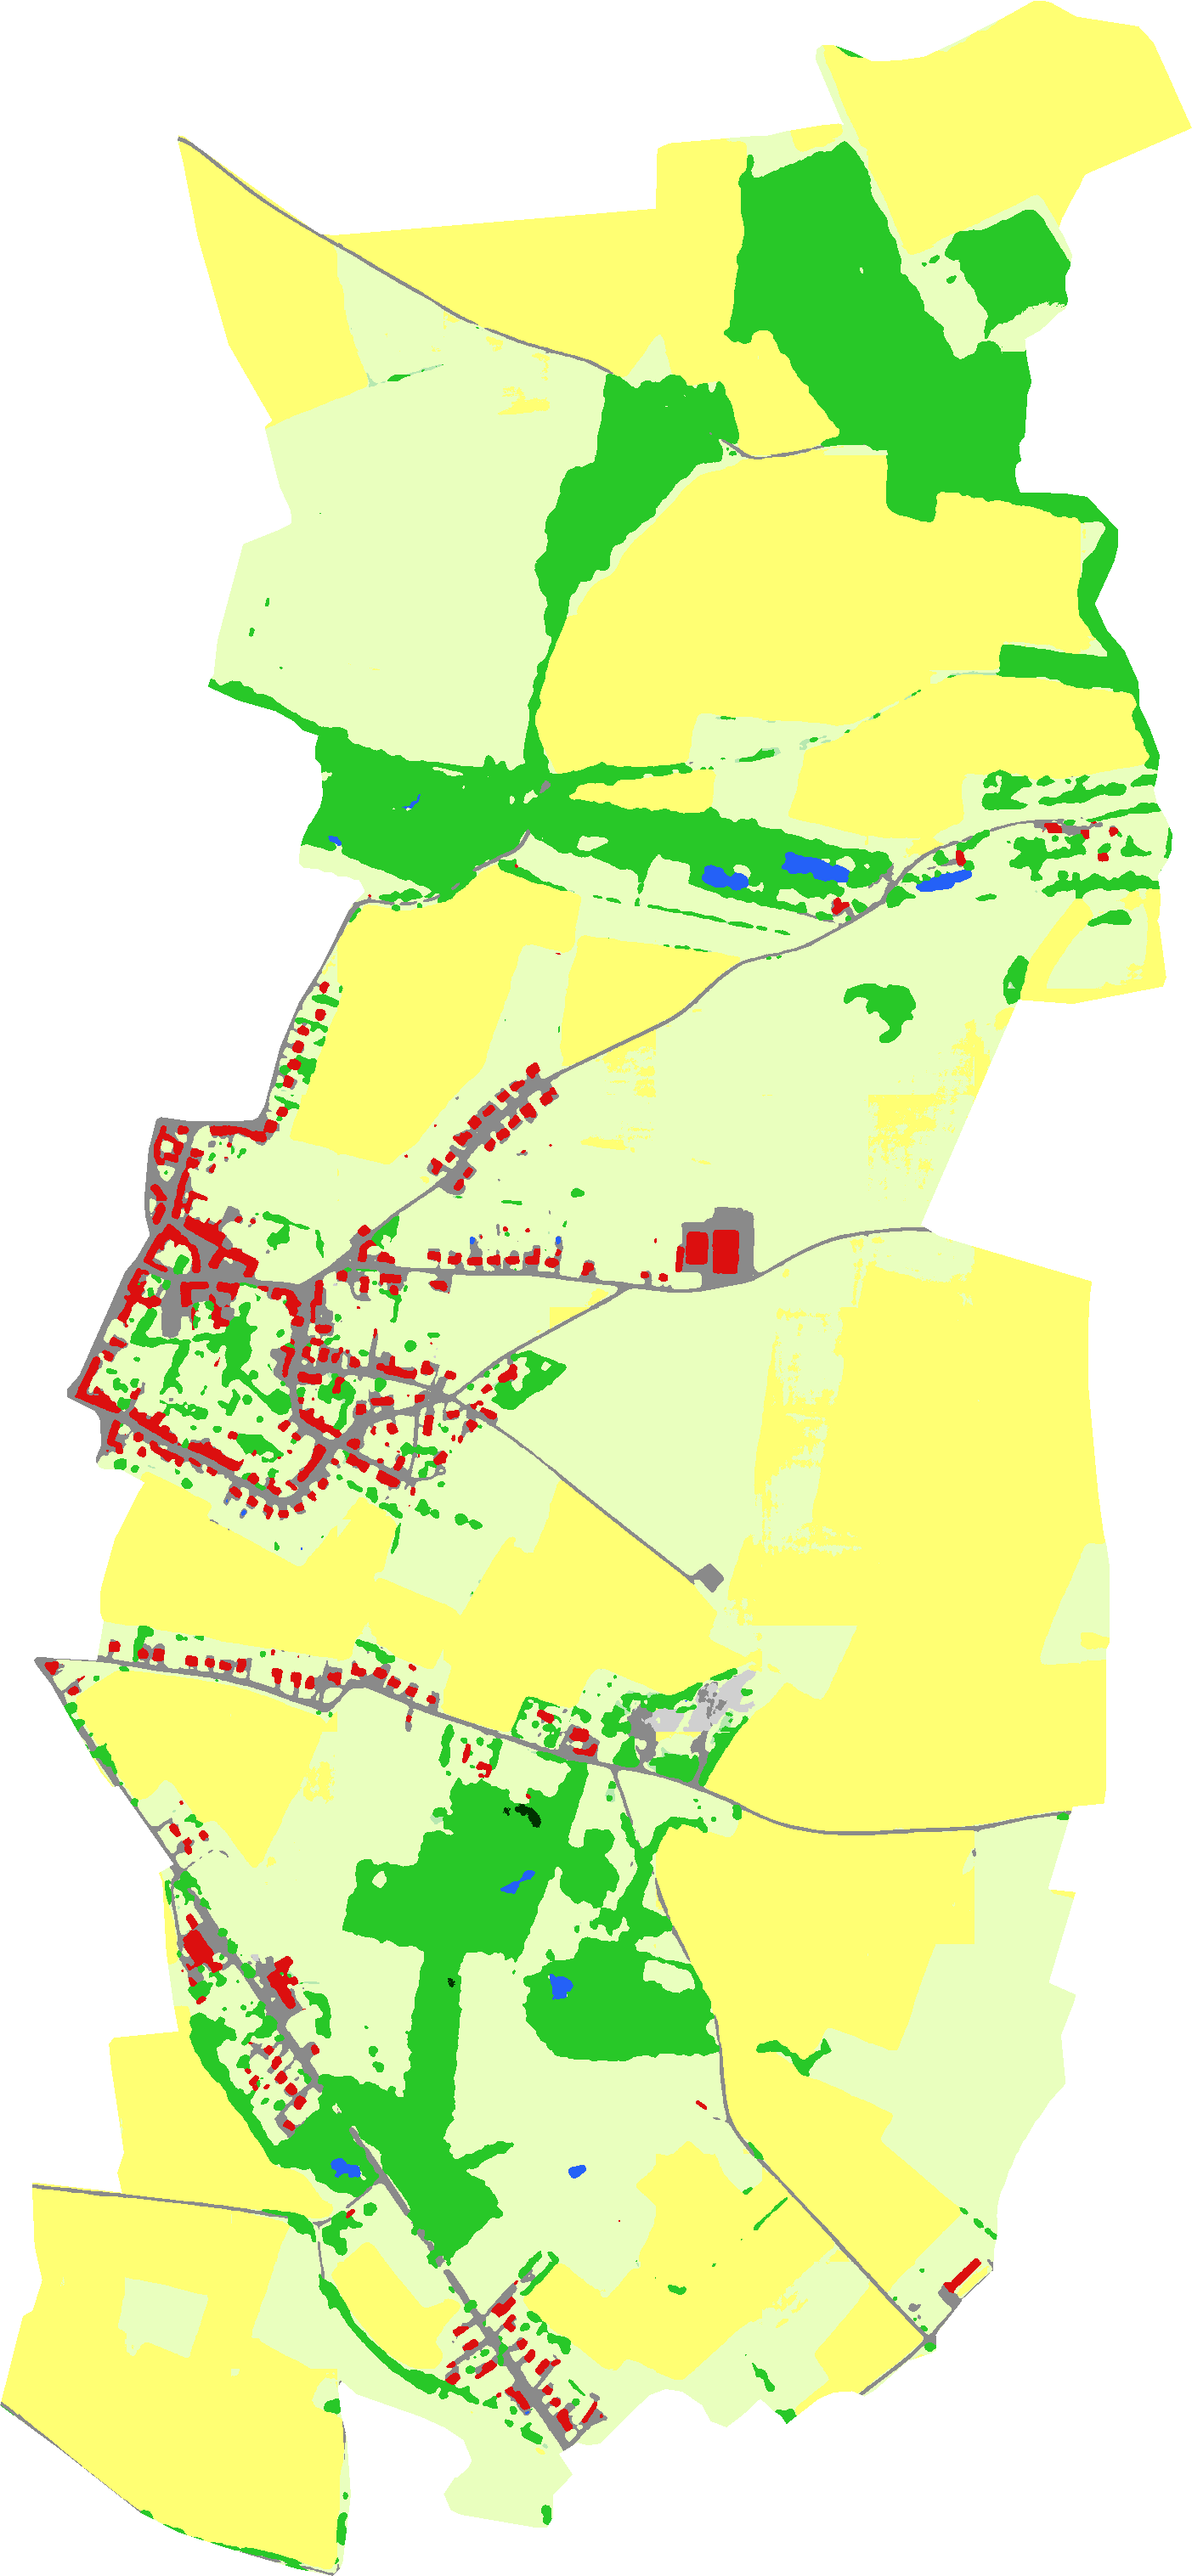

In [5]:
OCS_RASTER_FP = "data/WAL_OCS_IA_2019.tif"  # chemin relatif vers le raster WAL_OCS

with rio.open(OCS_RASTER_FP) as r:
    data, affine = mask(
        r,
        tuile.to_crs(r.crs).geometry,
        crop=True,
    )
    meta = r.meta
    meta["transform"] = affine

raster2img(data)

#### Vectorisation de la carte d'occupation du sol

Pour extraire et filtrer les piscines des zones d'eau, la vectorisation des données peut être souhaitable. Cela peut se faire via la fonction `features.shapes` de `rasterio`.<br>
Chaque zone homogène du raster est convertie en polygone et la valeur associée à cette zone extraite. Le tout est sauvé dans une `Feature` et l'ensemble de ces `Feature`s est stocké dans un `GeoDataFrame`.

_Note: Le paramètre `connectivity` propose deux options (4 ou 8) permettant de décider si les pixels de la même classe ne se touchant qu'en diagonale doivent faire partie du même polygone. L'option 4 ne considère comme voisins que les pixels du haut, bas, gauche, et droite d'un autre pixel. L'option 8 inclut les 4 autres positions découlant des deux diagonales._

In [6]:
features = []
for polygon, value in shapes(data, transform=affine, connectivity=4):
    features.append(Feature(geometry=polygon, properties={"label": int(value)}))
vect_gdf = gpd.GeoDataFrame.from_features(features, crs=meta["crs"])
# vect_gdf.to_file("data/piscine_vectorisation.shp")  # Sauver la donnée vectorielle
vect_gdf.head(5)

,geometry,label
0,"POLYGON ((663532.746 612640.347, 663532.746 61...",7
1,"POLYGON ((663344.747 612611.347, 663344.747 61...",9
2,"POLYGON ((663501.746 612624.347, 663501.746 61...",7
3,"POLYGON ((663345.747 612610.347, 663345.747 61...",9
4,"POLYGON ((662570.754 612506.348, 662570.754 61...",6


#### Filtration des surfaces d'eau

Les surfaces d'eau (label 5) sont extraites en selectionnant tous les polygones avec le label 5:

In [42]:
eau_gdf = vect_gdf[vect_gdf["label"] == 5].copy()

#### Calcul de la surface

Afin de différencier les piscines des autres étendues d'eau, nous pouvons, notamment, nous baser sur la surface des zones. Puisque nous travaillons avec des polygones, ceci peut très facilement être obtenu.<br>

Nous partirons de l'hypothèse que les piscines font moins de 50m², et utiliserons cela comme filtre.

In [43]:
FILTRE_SURFACE = 50  # en m² puisque le CRS est LB08
eau_gdf["area_filter"] = eau_gdf.geometry.area < FILTRE_SURFACE

#### Calcul de la `solidité`

Un autre facteur qui peut permettre de discriminer les piscines des autres étendues d'eau est la `solidité`.
La `solidité` est le ratio entre la surface couverte par le polygone et la surface de l'enveloppe convexe du polygone.<br>
Nous pouvons partir de l'hypothèse que les piscines étant principalement de forme convexe et que les étangs, etc. peuvent être concaves, nous estimerons qu'une faible "solidité" ne peut pas qualifier une piscine.

In [44]:
FILTRE_SOLIDITE = 0.75
eau_gdf["solidity"] = eau_gdf.geometry.area / eau_gdf.geometry.convex_hull.area
eau_gdf["solidity_filter"] = eau_gdf["solidity"] > FILTRE_SOLIDITE

#### Filtration des piscines

En utilisant conjointement ces deux filtres, nous pouvons maintenant extraire des surfaces d'eau tous les polygones qui répondent à nos critères et qui devraient représenter des piscines:

In [46]:
eau_gdf

,geometry,label,area_filter,solidity,solidity_filter
212,"POLYGON ((662853.752 611730.355, 662853.752 61...",5,False,0.511494,False
237,"POLYGON ((662747.752 611681.355, 662747.752 61...",5,False,0.833333,True
276,"POLYGON ((663287.748 611662.355, 663287.748 61...",5,False,0.852776,True
285,"POLYGON ((663196.749 611647.355, 663196.749 61...",5,False,0.846377,True
286,"POLYGON ((663492.746 611641.355, 663492.746 61...",5,False,0.883268,True
1026,"POLYGON ((662914.751 611209.359, 662914.751 61...",5,True,0.929293,True
1027,"POLYGON ((663015.750 611209.359, 663015.750 61...",5,True,0.929293,True
1588,"POLYGON ((662627.753 610900.362, 662627.753 61...",5,True,0.933333,True
1601,"POLYGON ((662646.753 610887.362, 662646.753 61...",5,True,0.865672,True
1661,"POLYGON ((662714.753 610843.362, 662714.753 61...",5,True,1.000000,True


In [49]:
eau_gdf["piscine"] = np.where(eau_gdf["solidity_filter"] & eau_gdf["area_filter"], True, False)
eau_gdf

,geometry,label,area_filter,solidity,solidity_filter,piscine
212,"POLYGON ((662853.752 611730.355, 662853.752 61...",5,False,0.511494,False,False
237,"POLYGON ((662747.752 611681.355, 662747.752 61...",5,False,0.833333,True,False
276,"POLYGON ((663287.748 611662.355, 663287.748 61...",5,False,0.852776,True,False
285,"POLYGON ((663196.749 611647.355, 663196.749 61...",5,False,0.846377,True,False
286,"POLYGON ((663492.746 611641.355, 663492.746 61...",5,False,0.883268,True,False
1026,"POLYGON ((662914.751 611209.359, 662914.751 61...",5,True,0.929293,True,True
1027,"POLYGON ((663015.750 611209.359, 663015.750 61...",5,True,0.929293,True,True
1588,"POLYGON ((662627.753 610900.362, 662627.753 61...",5,True,0.933333,True,True
1601,"POLYGON ((662646.753 610887.362, 662646.753 61...",5,True,0.865672,True,True
1661,"POLYGON ((662714.753 610843.362, 662714.753 61...",5,True,1.000000,True,True


In [50]:
piscine_gdf = eau_gdf[eau_gdf["piscine"]].copy()
etang_gdf = eau_gdf[~eau_gdf["piscine"]].copy()

#### Visualisation des résultats

Afin de visualiser les piscines, nous allons forcer les polygones identifiées comme représentant des piscines en utilisant la fonction de rasterisation de `rasterio`.

Nous assignons une nouvelle couleur et un nouveau label aux piscines ainsi identifiées.
Les autres étendues d'eau ont été converties en NODATA.

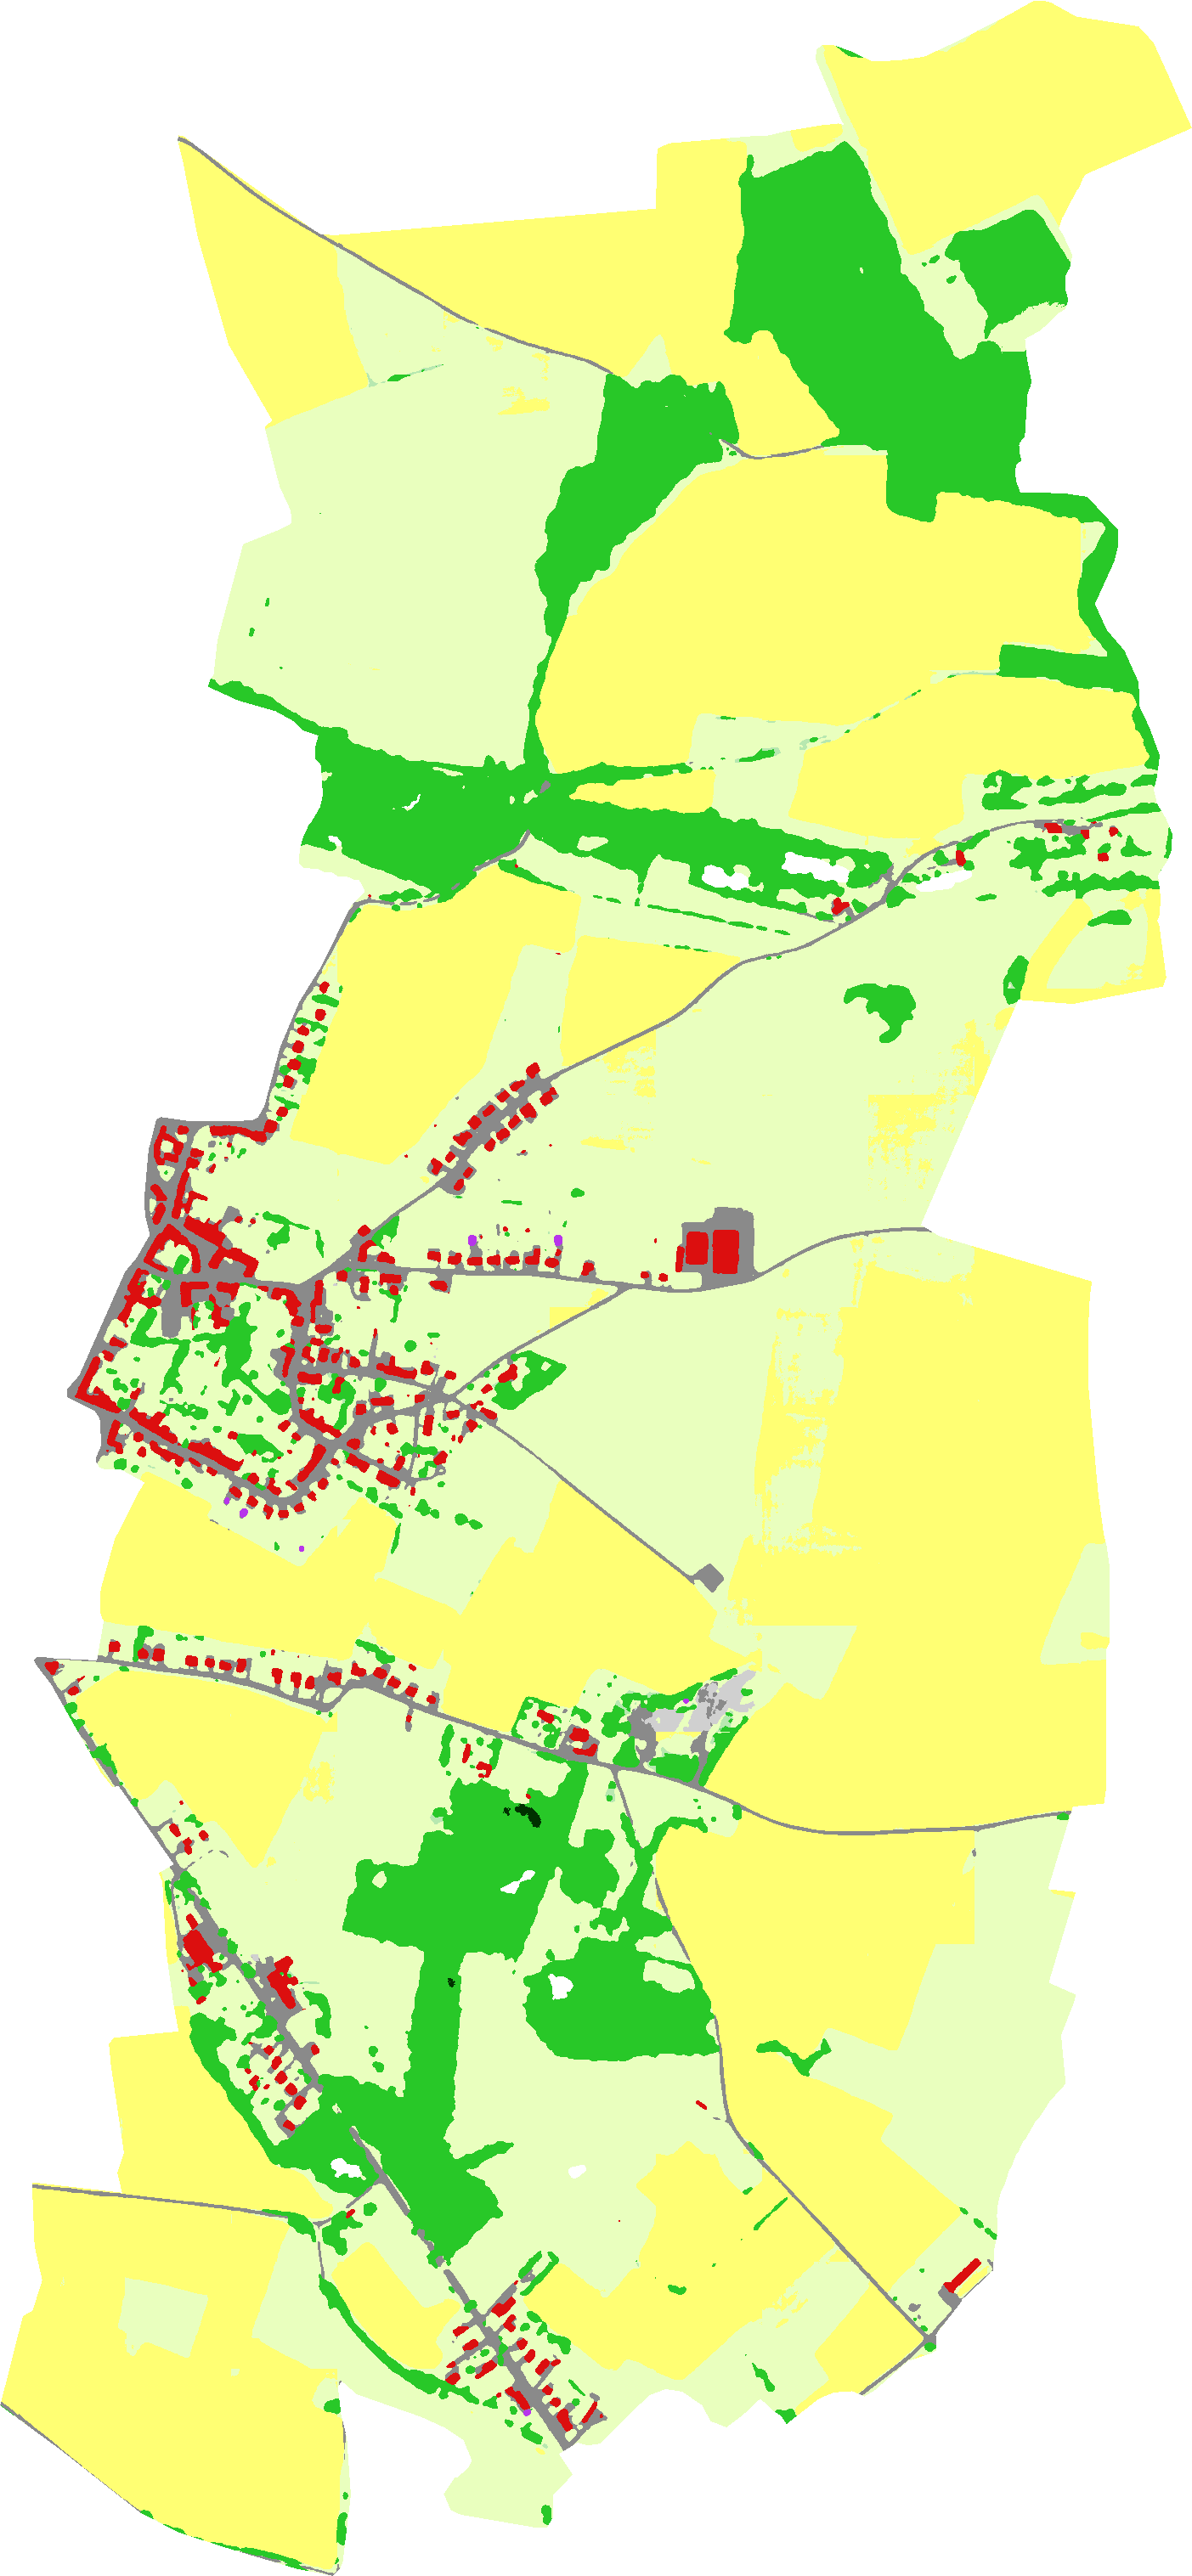

In [52]:
PISCINE_LABEL = 254
PISCINE_RGB = (183, 52, 235)  # Violet

data = rasterize(etang_gdf.geometry, out=data, default_value=255, transform=affine)
data = rasterize(
    piscine_gdf.geometry,
    out=data,
    default_value=PISCINE_LABEL,
    transform=affine,
)

new_cmap = deepcopy(OCS_CMAP)
new_cmap[PISCINE_LABEL] = PISCINE_RGB
raster2img(data, new_cmap)